In [50]:
import torch.nn as nn
import torch.nn.functional as F
import os
from enum import Enum
from typing import Tuple
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize, ToTensor, Normalize, Compose
from importlib import import_module
import pandas as pd
import argparse
import glob
import json
import multiprocessing
import random
import re
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter
import torch
import parser


In [51]:
class HyperParameter():
    EPOCH = 100
    BATCH_SIZE = 32
    RESIZE = (128, 96)
    SAVE_INTERVAL = 10
    IMAGE_DIR = '/opt/ml/input/data/train/images'
    CSV_DIR = '/opt/ml/input/data/train/train.csv'
    SEED = 42
    LEARNING_RATE = 0.001
    VALIDATION_RATIO = 0.2


In [52]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


In [53]:
class MaskLabels():
    MASK = 0
    INCORRECT = 1
    NORMAL = 2

    @classmethod
    def from_str(self, value: str) -> int:
        value = value.lower()
        if value in ["mask1", "mask2", "mask3", "mask4", "mask5"]:
            return self.MASK
        elif value == "incorrect_mask":
            return self.INCORRECT
        else:
            return self.NORMAL


class GenderLabels():
    MALE = 0
    FEMALE = 1

    @classmethod
    def from_str(self, value: str) -> int:
        value = value.lower()
        if value == "male":
            return self.MALE
        elif value == "female":
            return self.FEMALE
        else:
            raise ValueError(
                f"Gender value should be either 'male' or 'female', {value}")


class AgeLabels():
    YOUNG = 0
    MIDDLE = 1
    OLD = 2

    @classmethod
    def from_number(self, value: int) -> int:
        if value < 30:
            return self.YOUNG
        elif value < 60:
            return self.MIDDLE
        else:
            return self.OLD


In [54]:
class BasicDataset(Dataset):
    def __init__(self) -> None:
        self.image_paths = []
        self.mask_labels = []
        self.gender_labels = []
        self.age_labels = []
        IMG_EXTENSIONS = [".jpg", ".JPG", ".jpeg", ".JPEG",
                          ".png", ".PNG", ".ppm", ".PPM", ".bmp", ".BMP"]
        MASK_TYPES = ["mask1", "mask2", "mask3",
                      "mask4", "mask5", "incorrect_mask", "normal"]
        self.df = pd.read_csv(HyperParameter.CSV_DIR)
        for i in range(len(self.df)):
            row = self.df.iloc[i]
            p = os.path.join(HyperParameter.IMAGE_DIR, row.path)
            files = os.listdir(p)
            for mask_type in MASK_TYPES:
                for ext in IMG_EXTENSIONS:
                    if mask_type+ext in files:
                        self.image_paths.append(os.path.join(p, mask_type+ext))
                        self.mask_labels.append(MaskLabels.from_str(mask_type))
                        self.gender_labels.append(
                            GenderLabels.from_str(row.gender))
                        self.age_labels.append(
                            AgeLabels.from_number(row.age.item()))

    def __getitem__(self, index):
        return Image.open(self.image_paths[index]), [self.mask_labels[index], self.gender_labels[index], self.age_labels[index]]

    def __len__(self):
        return len(self.image_paths)


In [55]:
class SplitByHumanDataset(Dataset):
    def _get_images(self):
        IMG_EXTENSIONS = [".jpg", ".JPG", ".jpeg", ".JPEG",
                          ".png", ".PNG", ".ppm", ".PPM", ".bmp", ".BMP"]
        MASK_TYPES = ["mask1", "mask2", "mask3",
                      "mask4", "mask5", "incorrect_mask", "normal"]
        self.df = pd.read_csv(HyperParameter.CSV_DIR)
        for i in range(len(self.df)):
            row = self.df.iloc[i]
            p = os.path.join(HyperParameter.IMAGE_DIR, row.path)
            files = os.listdir(p)
            for mask_type in MASK_TYPES:
                for ext in IMG_EXTENSIONS:
                    if mask_type+ext in files:
                        self.image_paths.append(os.path.join(p, mask_type+ext))
                        self.mask_labels.append(MaskLabels.from_str(mask_type))
                        self.gender_labels.append(
                            GenderLabels.from_str(row.gender))
                        self.age_labels.append(
                            AgeLabels.from_number(row.age.item()))

    def _split_dataset_by_human(self):
        l = len(self.df)
        val_size = int(l*HyperParameter.VALIDATION_RATIO)
        self.val_index = []
        for c in random.choices(range(l), k=val_size):
            for i in range(7):
                self.val_index.append(c*7+i)
        self.train_index = list(set(range(len(self.image_paths)))-set(self.val_index))
        self.train_index.sort()
        self.val_index.sort()

    def __init__(self, train=True,transform=None) -> None:
        self.image_paths = []
        self.mask_labels = []
        self.gender_labels = []
        self.age_labels = []

        self.train = train
        self.transform = transform
        self._get_images()
        self._split_dataset_by_human()


    def __getitem__(self, index):
        if self.train:
            index=self.train_index[index]
        else:
            index=self.val_index[index]
        img =Image.open(self.image_paths[index]), [self.mask_labels[index], self.gender_labels[index], self.age_labels[index]]

        if self.transform:
            img=self.transform(img)
            
        return img

    def __len__(self):
        if self.train:
            return len(self.train_index)
        else:
            return len(self.val_index)


In [56]:
data = SplitByHumanDataset(train=True)



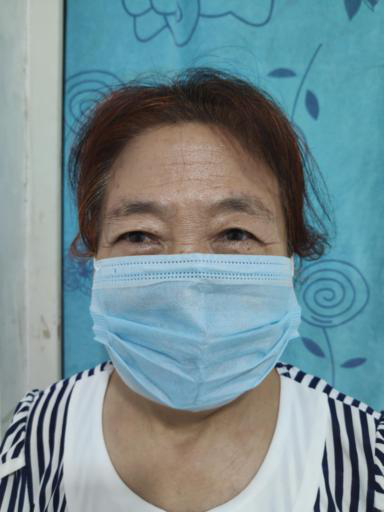

In [57]:
img, label = data[1002]
img